In [84]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 24 × 12th Gen Intel(R) Core(TM) i9-12900K
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, alderlake)
  Threads: 2 on 24 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/cuda/lib64


In [85]:
Sys.total_memory() / 2^20

63987.56640625

In [86]:
Sys.free_memory() / 2^20

56437.70703125

In [127]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra

In [128]:
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude("../First Band Approximation Functions.ipynb")
@nbinclude("../Braiding Utils.ipynb")
@nbinclude("../Aharonov-Bohm Phase.ipynb")
@nbinclude("../Hofstadter Many Body Utils.ipynb");

# Parameters

In [129]:
Nx=11
Ny=10
p=1
q=10
par_num = 4
U = 4 # On site interaction 

N=Nx*Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [i for i in 0:par_num];

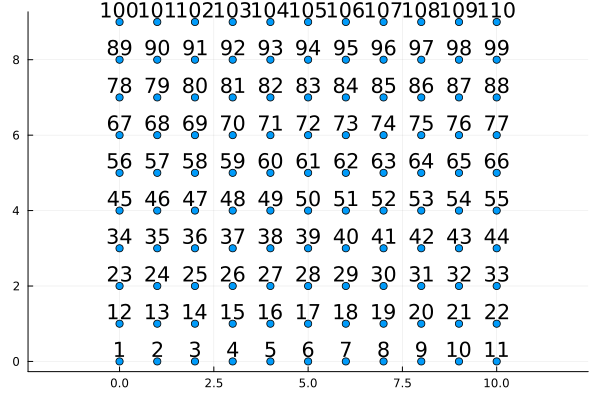

([0 0; 1 0; … ; 9 9; 10 9], nothing)

In [130]:
co, _ = plot_square_lattice(Nx, Ny)

In [131]:
# IMPURITY DATA
V_Strength = 10
V0 = [V_Strength, V_Strength]; Imp_Site = [31, 80]
N_Pin = length(V0[V0 .> 0]) # Number of pinning quasihole
Impurity_Data = Impurity(V0, Imp_Site)
factor = 10; # particle density interpolation factor

# PATHS

### 1. Exchange(x2) Path

In [132]:
# MOVING QUASIHOLES
start_point_1 = Impurity_Data.Imp_Site[1]
lens_1 = [4,5,4,5]
dirs_1 = [1, Nx, -1, -Nx]
rec_path_exch_1 = rectangular_path(start_point_1,lens_1,dirs_1)

start_point_2 = Impurity_Data.Imp_Site[2]
lens_2 = lens_1
dirs_2 = [-1, -Nx, 1, Nx]
rec_path_exch_2 = rectangular_path(start_point_2,lens_2,dirs_2);

In [133]:
println(" Nx= ",Nx," Ny= ", Ny, "alpha=", p/q, " N_phi= ", NPhi, " PN= ", par_num, " N_pin ", N_Pin, " N_eu=", lens_1[1], "x", lens_1[2])

 Nx= 11 Ny= 10alpha=0.1 N_phi= 11 PN= 4 N_pin 2 N_eu=4x5


In [134]:
# STEP CONTROL
delta_t = 0.01
STEP = 0:delta_t:1 # Braiding phases doesn't depend on the step size
println("Step size for braiding: ",length(STEP))

Step size for braiding: 101


### 2. Braiding Path

In [135]:
start_point = Imp_Site[1];

In [136]:
function get_braiding_path(start_point, Nx, Ny, co)
    First_Path = Int64[]
    mod_list = [mod(start_point,Nx),mod(start_point,Ny)]
    bottom_site_in_the_Ny_direction = mod_list[mod_list .> 0][1]
    last_site_in_the_Ny_direction = (bottom_site_in_the_Ny_direction+(Nx*(Ny-1)))
    site_number_from_upward = (last_site_in_the_Ny_direction-start_point)/Nx
    site_number_from_downward = (start_point-bottom_site_in_the_Ny_direction)/Nx
    for i in 0:site_number_from_upward
        step_site = start_point+i*Nx
        push!(First_Path, step_site)
        if step_site == last_site_in_the_Ny_direction
            for j in 0:site_number_from_downward
                push!(First_Path, bottom_site_in_the_Ny_direction+j*Nx)
            end
        end
    end
    A = findall(x->x==co[:,2][start_point],co[:,2])
    B = findall(x->x==start_point, A)[1]
    Second_Path = push!(vcat(reverse(A[1:B]),reverse(A[B+1:end])),start_point)
    return First_Path, Second_Path
end

get_braiding_path (generic function with 1 method)

In [137]:
First_Path, Second_Path = get_braiding_path(start_point, Nx, Ny, co);

In [138]:
Third_Path = reverse(First_Path)
Fourth_Path = reverse(Second_Path);

In [139]:
rec_path_braiding_1 = vcat(First_Path,Second_Path,Third_Path,Fourth_Path);

# Many-Body Spectrum

In [140]:
Degeneracy,_,_ = ground_degeneracy(Nx, Ny, p, q, N_Pin, PN)

(9, 4, 11.0)

0.0%┣                                               ┫ 0/11 [00:00<00:00, -0s/it]
9.1%┣████                                       ┫ 1/11 [00:00<Inf:Inf, InfGs/it]
18.2%┣████████▌                                      ┫ 2/11 [00:00<00:04, 2it/s]
27.3%┣████████████▉                                  ┫ 3/11 [00:01<00:03, 2it/s]
36.4%┣█████████████████                              ┫ 4/11 [00:01<00:03, 2it/s]
45.5%┣█████████████████████▍                         ┫ 5/11 [00:02<00:03, 2it/s]
54.5%┣█████████████████████████▋                     ┫ 6/11 [00:03<00:03, 2it/s]
63.6%┣██████████████████████████████                 ┫ 7/11 [00:03<00:02, 2it/s]
72.7%┣██████████████████████████████████▏            ┫ 8/11 [00:04<00:02, 2it/s]
81.8%┣██████████████████████████████████████▌        ┫ 9/11 [00:05<00:01, 2it/s]
90.9%┣█████████████████████████████████████████▉    ┫ 10/11 [00:06<00:01, 2it/s]
100.0%┣█████████████████████████████████████████████┫ 11/11 [00:07<00:00, 2it/s]
100.0%┣█████████████████████

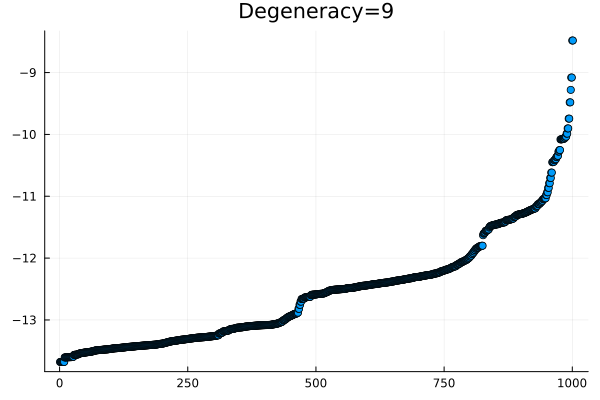

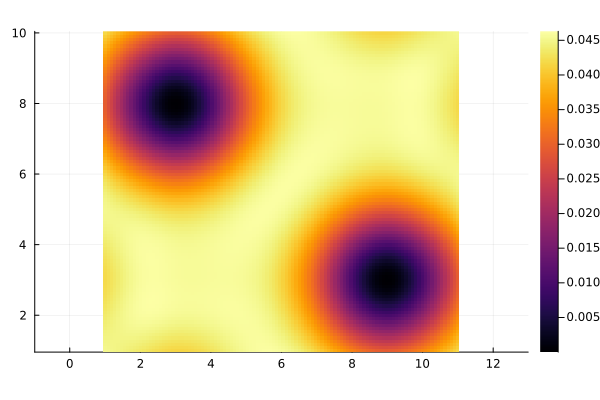

 24.925601 seconds (3.72 M allocations: 72.122 GiB, 9.38% gc time, 3.68% compilation time)


In [141]:
E, Sub_Number_MB_Operator_List, basis_cut_mb, Degeneracy, Total_H, Sub_Number_MB_Operator_List, r_hubbard_states, pn, NPhi0 = @time Get_MB(N, Nx, Ny, p, q, cut_off, PN, U, Impurity_Data);

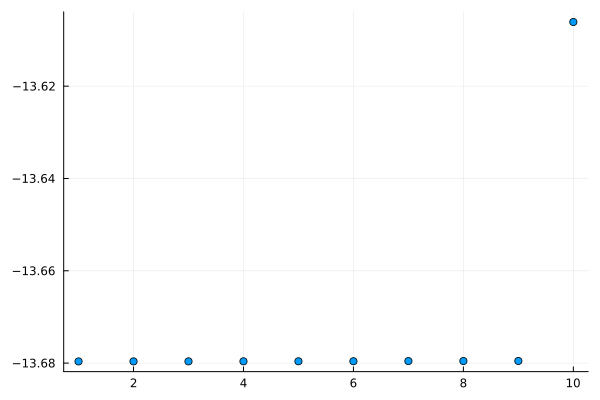

In [142]:
scatter(E[1:Degeneracy+1], legend=:false)

# $\Phi_{AB}$

In [143]:
N_Pin

2

In [144]:
# AB PHASE
pn = maximum(PN)
charge = pn/(NPhi-N_Pin)

0.4444444444444444

In [145]:
NPhi

11

In [146]:
p/q

0.1

In [147]:
N_mov = 1

1

In [148]:
number_of_plaq = Nx*Ny
power = N_mov * (p/q) * charge * number_of_plaq
AB_phase = exp(2*im*pi*power)

0.7660444431189778 - 0.6427876096865397im

In [149]:
power

4.888888888888889

# $\nu \neq 1/2$

In [150]:
# AB Phase
(((4/9)*(1/10))*(11*10))-(9*0.11) # Toplamlar

3.898888888888889

In [151]:
# 2*(4/9)
8/9

0.8888888888888888

In [152]:
(((3/7)*(1/9))*81)-(7*0.14)

2.877142857142857

In [153]:
6/7

0.8571428571428571

In [154]:
(((3/8)*(1/10))*(10*10))-(9*0)

3.7500000000000004

In [155]:
6/8

0.75

# Phases

In [156]:
# AB (N_p=1)
# rec_path_1 = rec_path_exch_1
# rec_path_2 = rec_path_1;

# EXCHANGE
# rec_path_1 = rec_path_exch_1
# rec_path_2 = rec_path_exch_2

# rec_path_1 = [29,30,31,42,53,52,51,40,29]
# rec_path_2 = repeat([Imp_Site[2]],length(rec_path_1));

# BRAIDING
rec_path_1 = rec_path_braiding_1
rec_path_2 = repeat([Imp_Site[2]],length(rec_path_1));

In [157]:
function plot_paths(co, First_Path, Second_Path)
    M = Matrix{Int64}(undef,length(First_Path),2)
    N = Matrix{Int64}(undef,length(Second_Path),2)
    for (idx,value) in enumerate(First_Path)
            M[idx,:] = co[value,:]
    end
    for (idx,value) in enumerate(Second_Path)
            N[idx,:] = co[value,:]
    end
    p1 = scatter(co[:,1],co[:,2], series_annotations = text.([i for i in 1:Nx*Ny], :bottom), legend=false, aspect_ratio = :equal)
    p2 = plot!(M[:, 1], M[:, 2], linewidth=2, c=:blue,legend=:false)
    p3 = plot!(N[:, 1], N[:, 2], linewidth=2, c=:red,legend=:false)
    return display(p3)
end

plot_paths (generic function with 1 method)

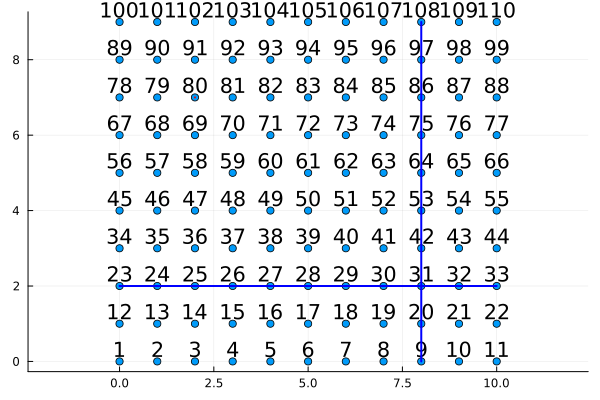

In [158]:
plot_paths(co, rec_path_1, rec_path_2)

In [159]:
@nbinclude("../Hofstadter Many Body Utils.ipynb");

In [160]:
ψ, ψ_first, Ψ_list, ϕ_tot, BerryEnergies, M_Matrix_List = @time optimized_get_braiding_phase(Impurity_Data,rec_path_1,rec_path_2, Imp_Site, Total_H, Sub_Number_MB_Operator_List, Degeneracy);

686.005192 seconds (1.40 M allocations: 649.855 GiB, 1.76% gc time, 0.05% compilation time)


In [161]:
ϕ_tot

1.1102230246251565e-14

In [95]:
M_Matrix_List[5]

9×9 Matrix{ComplexF64}:
     0.451379+0.177723im    0.0991569+0.0991504im  …  0.00686386+0.0938184im
     0.114398-0.26809im      0.341921-0.0464084im      0.0833438+0.188782im
     0.658546+0.353041im    -0.114577-0.184493im       -0.180395-0.0719093im
    0.0246453-0.119093im    -0.662796+0.203256im       -0.111576+0.0666309im
    -0.119606+0.136864im    -0.399354+0.305751im       -0.128492-0.104465im
     0.227079-0.0351056im   -0.131397+0.104866im   …    0.543207-0.377239im
 -0.000867802-0.078458im     0.105839-0.159617im       -0.465046-0.0772185im
    0.0836783-0.00694529im  0.0464689+0.0412423im       0.226904-0.352487im
    0.0470933+0.0730865im   0.0468157-0.0976535im     -0.0411884+0.171751im

In [96]:
(ψ' * ψ_first)' - (ψ' * ψ_first)

9×9 Matrix{ComplexF64}:
        0.0-0.373998im      0.249312+0.185527im    …   0.0893349-0.155103im
  -0.249312+0.185527im           0.0-0.138355im        0.0244637-0.176664im
    0.14673-0.23663im       0.259504+0.0624753im        0.454776-0.212618im
  0.0559928-0.08127im       0.261865-0.0687194im       -0.150784-0.140433im
 -0.0458481+0.37187im      -0.132131+0.549975im       -0.0550175-0.093091im
  -0.294905+0.0310601im    -0.159864-0.191812im    …  -0.0415253-0.201525im
   0.146386+0.0248059im    -0.225793+0.107921im       -0.0930937+0.054914im
   0.173788+0.00469492im  -0.0118534-0.00277222im      -0.102668-0.0886203im
 -0.0893349-0.155103im    -0.0244637-0.176664im              0.0+0.426961im

In [162]:
BerryEnergies

9-element Vector{ComplexF64}:
 -0.9971927721344019 - 0.07487706726966467im
 -0.9954622266708741 + 0.09515752871666132im
 -0.9882573855833071 - 0.15279836334216965im
 -0.9559437039913938 + 0.29355005501483844im
 -0.9335591248640294 + 0.3584234372681375im
  -0.798499211432649 + 0.6019958549204791im
  -0.776911999730433 + 0.6296091999604687im
  0.7832366753424522 - 0.6217236607999559im
   0.818425607166799 - 0.5746125003283995im

### $\phi_{Berry} = \phi_{Braiding} + \phi_{AB} = 2\nu_{eff} + \nu_{eff} \alpha N_{eu}$ where $\phi_{Berry} \coloneqq \frac{\sum_B}{D}, \nu_{eff}=\frac{PN}{N_{phi}-N_{pin}}$

In [163]:
A = []
for i in 1:length(BerryEnergies)
    push!(A,imag(log(BerryEnergies[i])/(2*pi)))
end

In [164]:
round.(A,digits=5)

9-element Vector{Float64}:
 -0.48807
  0.48483
 -0.47559
  0.45258
  0.44166
  0.39719
  0.39161
 -0.10678
 -0.09742

In [165]:
sum(A) # CHERN ?
# N_p = 2 ama N_mov = 1 iken tam sayı değil ! (Onur hocanın paylaştığı dosyada \alpha N_eu tam sayı olursa, toplamları da tam sayıdır!)

0.9999999999999976

In [126]:
Berry = sum(A)/length(A) # AB for this parameter set

0.2857142857142864

In [397]:
isapprox(M_Matrix_List[1], I) # true
M_Matrix_List[2]

2×2 Matrix{ComplexF64}:
 -0.724311-0.526711im  0.227333-0.38245im
 -0.183951+0.405106im  0.846141+0.293423im

In [392]:
M_Matrix_List[9018]

2×2 Matrix{ComplexF64}:
 -0.605275+0.563156im   0.413001+0.382005im
  0.468476+0.311492im  -0.404881+0.720815im

In [393]:
ψ' * ψ_first

2×2 Matrix{ComplexF64}:
 -0.989421+0.00525861im  -0.0861792-0.11658im
 0.0861792-0.11658im      -0.989421-0.00525861im

In [394]:
imag(log(-0.989424+0.00524999im)/(2*pi))

0.4991555147053944

# Theoric vs Numeric AB

In [95]:
# FOR XXX TABLE
N_euu = 4

# FOR XXXX TABLE
N_euu = 2

# FOR XXXX TABLE
N_euu = 4

N_mov*(p/q)*charge*N_euu #AB (N_eu=2)

0.17777777777777778

In [97]:
# Berry variable fully numerical result
((-Berry/N_euu)*(Nx*Ny)) #Theoric \Phi value from Tables

4.898319523031905

In [ ]:
2/7 # Berry phase from Table XX

In [44]:
-(2/7)-(3.8571428571428568)

-4.142857142857142

In [45]:
-0.142857142857142+1 # Q (Charge) or braiding phase we expected from table XX

0.857142857142858

In [51]:
(1 * (1/10) * (3/8) * 10 * 10) # Teorik AB

3.7500000000000004

In [55]:
(2/16)-3.7500000000000004

-3.6250000000000004

In [56]:
-0.6250000000000004+1

0.37499999999999956

In [ ]:
# Toplantı sonrası hesabı başka parametre seti içinde yap!
# A = Figure-C yap
# B = Figure-C'de ki hareketli qh'i diğerini kapsamayacak bir loop içine al.

In [ ]:
# 3.0.1 Figure-C (Braiding) Path başlığı altında N_pin = 1 iken tablonun kendi içerisinde bir karşılaştırma
# yapmak mantıksız, çünkü Brading fazı yok burada!

# Massive Degenerate Manifold ($\nu \neq 1/2$)

In [41]:
power-sum(A)

2.499999999999967

In [42]:
2*charge

1.0

In [43]:
charge

0.5

In [44]:
# angle(BP[1])/pi

In [45]:
# angle(BP[2])/pi

In [46]:
# exp(1im*pi*-0.007817146433728302)

In [47]:
# rad2deg(angle(BP[1])/pi)

In [48]:
# rad2deg(angle(BP[2])/pi)

In [49]:
# sum(BP)

In [50]:
# imag(log(BP[1])/pi)+imag(log(BP[2])/pi)

In [51]:
# E[1:8]

In [52]:
# angle(1+1im)

In [53]:
# exp(1im*pi/4)

In [54]:
# cos(pi/4)+1im*sin(pi/4)

In [55]:
# angle(exp(1im*pi/4))

In [56]:
# imag(log(exp(1im*pi/4))/pi)

In [57]:
# 1/4

# Movie of QH's

In [58]:
# length(Eigen_List)

In [59]:
# @gif for i in 1:300
#     data = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[i])'
#     heatmap(Interp(data, factor), aspect_ratio=:equal)
# end

In [60]:
# PNN = 10

In [61]:
# NPhi=2*PNN+2

In [62]:
# A = NLevelBasis(NPhi)

In [63]:
# B = bosonstates(A, PNN)
# length(B)